In [1]:
__nbid__ = '0060'
__author__ = 'Giada Pastorelli <gpastorelli.astro@gmail.com>'
__version__ = '20240601' # yyyymmdd
__datasets__ = ['lsst_sim']
__keywords__ = ['science example', 'tutorial', 'Milky Way', 'catalogues', 'plot:histogram', 'plot:cmd', 'plot:color-color']

# Color-magnitude and color-color diagrams of the South Galactic Pole

*Giada Pastorelli*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [SQL query](#chapter1)
* [Getting useful data](#chapter2)
* [Color-magnitude and color-color diagrams](#chapter3)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
## Goals
Plots of color-magnitude and color-color diagrams of the simulated South Galactic Plot population.
The plots refer to the single star version of the simulated catalog.
Plots are color-coded according to a set of stellar and population parameters.

## Summary
We show an example of retrieving data from the table `lsst_sim.simdr2` for the region of the South Galactic Pole (SGP), i.e.
sources with galactic longitude $b <= -85$ degrees.
We plot the resulting sources in terms of both color-magnitude and color-color diagrams in some LSST filters.
We also show the corresponding Hess diagrams color-coded according to stellar and population parameters, such as 
surface gravity, effective temperature, galactic component and more.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution

Disclaimers
-----------
Note that using the Astro Data Lab constitutes your agreement with our minimal [Disclaimers](https://datalab.noirlab.edu/disclaimers.php).

Acknowledgments
---------------
If you use **Astro Data Lab** in your published research, please include the text in your paper's Acknowledgments section:

_This research uses services or data provided by the Astro Data Lab, which is part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

If you use **SPARCL jointly with the Astro Data Lab platform** (via JupyterLab, command-line, or web interface) in your published research, please include this text below in your paper's Acknowledgments section:

_This research uses services or data provided by the SPectra Analysis and Retrievable Catalog Lab (SPARCL) and the Astro Data Lab, which are both part of the Community Science and Data Center (CSDC) Program of NSF NOIRLab. NOIRLab is operated by the Association of Universities for Research in Astronomy (AURA), Inc. under a cooperative agreement with the U.S. National Science Foundation._

In either case **please cite the following papers**:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://doi.org/10.1117/12.2057445

* Astro Data Lab overview: Nikutta et al., "Data Lab - A Community Science Platform", Astronomy and Computing, 33, 2020, https://doi.org/10.1016/j.ascom.2020.100411

If you are referring to the Data Lab JupyterLab / Jupyter Notebooks, cite:

* Juneau et al., "Jupyter-Enabled Astrophysical Analysis Using Data-Proximate Computing Platforms", CiSE, 23, 15, 2021, https://doi.org/10.1109/MCSE.2021.3057097

If publishing in a AAS journal, also add the keyword: `\facility{Astro Data Lab}`

And if you are using SPARCL, please also add `\software{SPARCL}` and cite:

* Juneau et al., "SPARCL: SPectra Analysis and Retrievable Catalog Lab", Conference Proceedings for ADASS XXXIII, 2024
https://doi.org/10.48550/arXiv.2401.05576

The NOIRLab Library maintains [lists of proper acknowledgments](https://noirlab.edu/science/about/scientific-acknowledgments) to use when publishing papers using the Lab's facilities, data, or services.

For this notebook specifically, please acknowledge:

* LSST White paper: Dal Tio et al., 2022, "Simulating the Legacy Survey of Space and Time Stellar Content with TRILEGAL", ApJS, 262, 22. <https://doi.org/10.3847/1538-4365/ac7be6>

<a class="anchor" id="import"></a>
## Imports and setup

In [ ]:
# std lib
from getpass import getpass

# 3rd party # remove imports that are not needed
import numpy as np
import pylab as plt
from astroML.stats import binned_statistic_2d
import matplotlib.colors as colors
import statistics
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc

# Plotting functions
from utils import plot_2D_hess, make_cbar

<a class="anchor" id="auth"></a>
## Authentication
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab, un-comment the cell below and execute it:

In [3]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
ac.whoAmI()

'demo00'

<a class="anchor" id="chapter1"></a>
## SQL query

Here we define a function to perform the query needed to retrieve the simulated sources in the South Galactic Pole (SGP).
We will get all sources in the SGP, i.e. sources with $b <= -85$ degrees. 
As optional argument, you can specify a magnitude limit in the LSST r-band.
With a limiting magnitude in the r-band equal to 20, you'll get  96830 objects.
If you need all the sources in the SGP, you will get 1567784 objects.

In [4]:
# Query to retrieve sources in the SGP
# If you want to limit the sample using a specific
# magnitude limit use the `rmag_lim` argument

def get_sgp_query(rmag_lim = None):
    query=\
    """SELECT umag, gmag, rmag, Gc, logg, logte, m_ini, mass, m_h,mu0
       FROM lsst_sim.simdr2
       WHERE galb <= -85"""
    if rmag_lim is not None:
        query += " AND rmag_lim <= {:.2f}".format(rmag_lim)

    return query    

For this example we use the query with no limiting magnitude (1567784 objects).

In [5]:
# For this example we use the query with no limiting magnitude
sgp_query = get_sgp_query() 
print (sgp_query)

SELECT umag, gmag, rmag, Gc, logg, logte, m_ini, mass, m_h,mu0
       FROM lsst_sim.simdr2
       WHERE galb <= -85


In [6]:
#to use the query with the limiting magnitude, for instance a limit of 20 in the r-band you can do the following
#sgp_query = get_sgp_query(rmag_lim = 20)
#print(sgp_query)

With our selected query, we now retrieve the data and print the number of objects and the first rows of the table

In [7]:
R = qc.query(sql=sgp_query,fmt='pandas') # R is a pandas DataFrame
print("Number of objects:", R.shape[0])
print(R.head())

Number of objects: 1567784
     umag    gmag    rmag  gc   logg   logte    m_ini   mass   m_h    mu0
0  28.045  26.450  25.768   3  4.722  3.6889  0.56233  0.561 -1.16  18.85
1  30.893  28.471  27.245   3  5.270  3.5925  0.13020  0.130 -2.10  16.10
2  28.400  25.772  24.460   3  4.865  3.5771  0.40501  0.404 -0.70  15.20
3  30.797  27.107  25.444   1  5.277  3.4378  0.09700  0.097 -0.64   9.65
4  18.700  17.715  17.252   3  2.915  3.7301  0.80042  0.798 -2.19  15.65


<a class="anchor" id="chapter2"></a>
## Getting useful data

Note: the column `gc` reports the galactic component a star belongs to. For this notebook, the important ones are:

- 1 -> thin disk 
- 2 -> thick disk
- 3 -> halo

More details are given in Table 4 of the [paper](https://iopscience.iop.org/article/10.3847/1538-4365/ac7be6#apjsac7be6t4).

In [8]:
# Get useful data
umag = R['umag'] # LSST u mag
gmag = R['gmag'] # LSST g mag
rmag = R['rmag'] # LSST r mag
logg = R['logg'] # surface gravity log(g)
logte = R['logte'] # effective temperature log(Teff)
gc = R['gc'] # Galactic component
mh = R['m_h'] # Initial metallicity
mu0 = R['mu0'] # Distance modulus
log_distPc = 1. + 0.2*mu0 # Log distance(pc)

In [9]:
# This is used to calculate the mode of specific parameters
# such as the Galactic Component associated to a simulated star 
# If the sample of a bin is multimodal, it returns the first found mode value
def multimode_gc (x):
    mm = statistics.multimode(x)
    return mm[0]

<a class="anchor" id="chapter3"></a>
## Color-magnitude and color-color diagrams

First, we plot a simple CMD in the LSST filters r vs. (g-r)

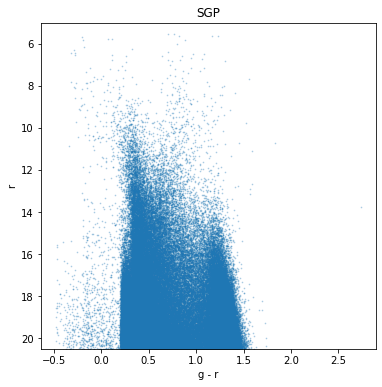

In [10]:
# Plot LSST r vs. (g-r) CMD
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(gmag - rmag, rmag, s = 0.5, alpha=0.3)
ax.set_xlabel('g - r')
ax.set_ylabel('r')
ax.invert_yaxis()
ax.set_ylim(20.5,5)
ax.set_title("SGP");

We make the histograms of the stellar parameters that we are interested in.

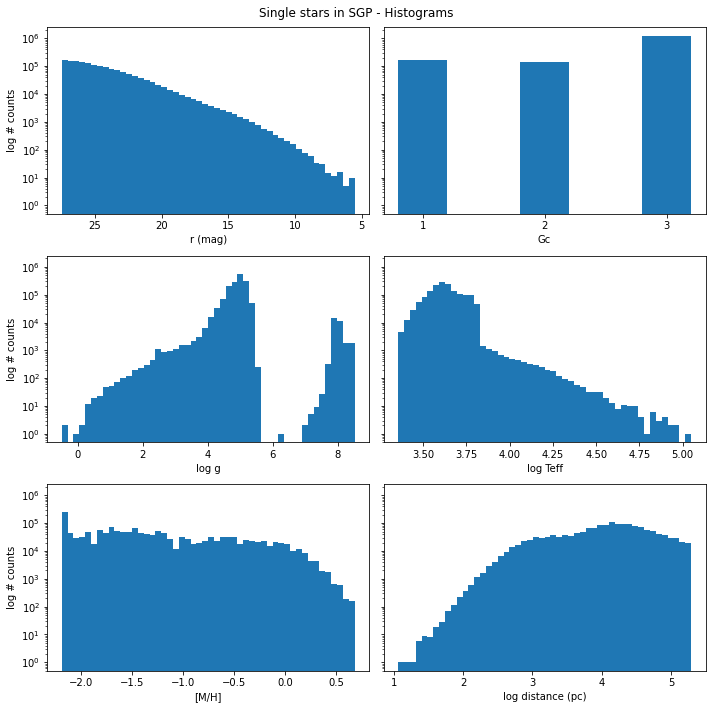

In [11]:
# 6 panel plots for number counts in r(mag), Galactic Components, surface gravity, effective temperature
# metallicity, and distance

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3,2, sharey = True, figsize = (10,10))

# 1. r-mag
ax0.hist(rmag, bins=50)
ax0.set_xlabel("r (mag)")
ax0.invert_xaxis()

# 2. Galactic Components 
gc_label, gc_counts = np.unique(gc, return_counts=True)
ax1.bar(gc_label, gc_counts, align='center', width=0.4)
ax1.set_xlabel("Gc")
ax1.set_xticks(gc_label)

# 3. Surface gravity
ax2.hist(logg, bins=50)
ax2.set_xlabel("log g")

# 4. Effective Temperature
ax3.hist(logte, bins=50)
ax3.set_xlabel("log Teff")

# 5. Metallicity
ax4.hist(mh, bins=50)
ax4.set_xlabel("[M/H]")

# 6. log distance(pc)
ax5.hist(log_distPc, bins=50)
ax5.set_xlabel("log distance (pc)")

for ax in fig.axes:
    ax.set_yscale("log")

#Axis labels
for ax in [ax0,ax2, ax4]:
    ax.set_ylabel("log # counts")

# Set a title for the entire figure
plt.suptitle("Single stars in SGP - Histograms")

# Use tight_layout
plt.tight_layout()


Next, we plot the Hess diagram r vs. (g-r) with bins color-coded according to specific stellar parameters

In [12]:
# Define the number of bins in color and magnitude
bins = (100,100)

In the following, we use the function "binned_statistic_2d()" to get our Hess diagrams. 
Note the different statistics used for different parameters

In [13]:
# Hess diagram color-coded according to the median surface gravity 

Hlogg, xed1, yed1 = binned_statistic_2d(gmag-rmag, rmag, logg, statistic='median', bins=bins)

# Hess diagram color-coded according to the median effective temperature
Hlogte, xed1, yed1 = binned_statistic_2d(gmag-rmag, rmag, logte, statistic='median', bins=bins)

# Hess diagram color-coded according to the Galactic Component, here we use the multimode function
Hgc, xed1, yed1 = binned_statistic_2d(gmag-rmag, rmag, gc, statistic=multimode_gc, bins=bins)

# Hess diagram color-coded according to the stellar density, here we use the 'count' statistic
H, xed1, yed1 = binned_statistic_2d(gmag-rmag, rmag, None, statistic='count', bins=bins)

# Hess diagram color-coded according to the median metallicity 
Hmet, xed1, yed1 = binned_statistic_2d(gmag-rmag, rmag, mh, statistic='median', bins=bins)

# Hess diagram color-coded according to the median log(distance(pc))
Hlogdist, xed1, yed1 = binned_statistic_2d(gmag-rmag, rmag, log_distPc, statistic='median', bins=bins)

Then, we make a 6-panel plot showing the Hess diagrams for the selected stellar parameters.

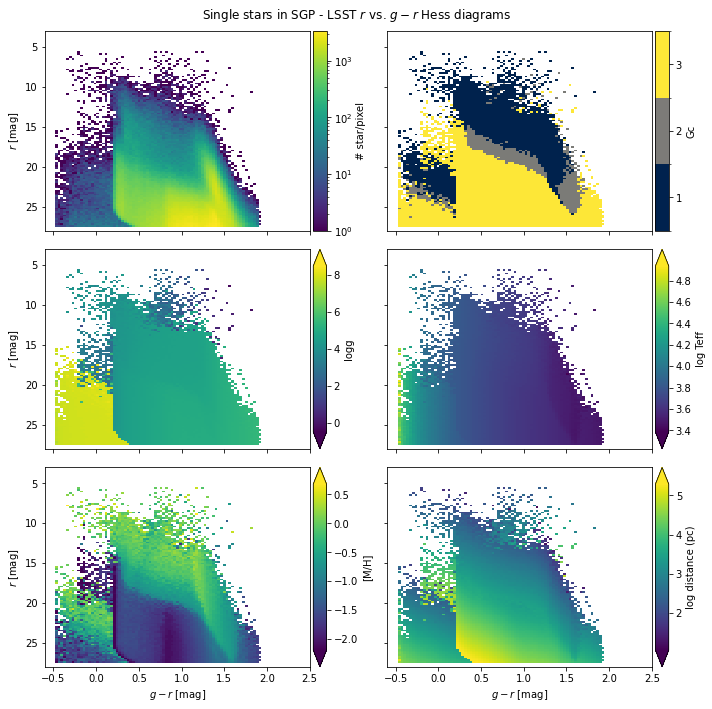

In [14]:
# 6 panel plot - CMDs

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3,2, sharex = True, sharey= True, figsize = (10,10))

# 1. Stellar density
norm = colors.LogNorm(1, np.max(H))
cc = plot_2D_hess(H, xed1, yed1, ax = ax0, norm=norm)
make_cbar(ax0, cc, "# star/pixel",  extend = None)

# 2. Galactic Components 
#    Custom normalization
ccmap = plt.get_cmap('cividis')
boundaries = np.arange(0.5, 3.6, 1)
norm_gc = colors.BoundaryNorm( boundaries, ccmap.N)
#   Plot Hess diagram
cc = plot_2D_hess(Hgc, xed1, yed1,  ax = ax1, cmap = ccmap, norm = norm_gc)
#   Make colorbar with some non-default options
cb = make_cbar(ax1, cc, "Gc", boundaries = boundaries, extend = None)
cb.set_ticks(0.5*( boundaries[1:] + boundaries[:-1]) )

# 3. Surface gravity
cc = plot_2D_hess(Hlogg, xed1, yed1, ax = ax2)
make_cbar(ax2, cc, "logg")

# 4. Effective Temperature
cc = plot_2D_hess(Hlogte, xed1, yed1, ax = ax3)
make_cbar(ax3, cc, "log Teff")

# 5. Metallicity
cc = plot_2D_hess(Hmet, xed1, yed1, ax = ax4)
make_cbar(ax4, cc, "[M/H]")

# 6. log distance(pc)
cc = plot_2D_hess(Hlogdist, xed1, yed1, ax = ax5)
make_cbar(ax5, cc, "log distance (pc)")
# Set up limits for the x and y axis
ax1.set_ylim(28, 3)
ax1.set_xlim(-0.6, 2.5)

# Axis labels
for ax in [ax0,ax2, ax4]:
    ax.set_ylabel("$r$ [mag]")
for ax in [ax4,ax5]:
    ax.set_xlabel("$g - r$ [mag]")

# Set a title for the entire figure
plt.suptitle("Single stars in SGP - LSST $r$ vs. $g-r$ Hess diagrams")

# Use tight_layout
plt.tight_layout()

In the following, we plot the color-color diagrams (g - r) vs. (u - g) in the form of Hess diagrams color-coded according to the same parameters used above for the CMDs

In [15]:
# Hess diagram color-coded according to the median surface gravity 
H2logg, xed1, yed1 = binned_statistic_2d(umag-gmag, gmag-rmag, logg, statistic='median', bins=bins)

# Hess diagram color-coded according to the median effective temperature
H2logte, xed1, yed1 = binned_statistic_2d(umag-gmag, gmag-rmag, logte, statistic='median', bins=bins)

# Hess diagram color-coded according to the Galactic Component, here we use the multimode function
H2gc, xed1, yed1 = binned_statistic_2d(umag-gmag, gmag-rmag, gc, statistic=multimode_gc, bins=bins)

# Hess diagram color-coded according to the stellar density, here we use the 'count' statistic
H2, xed1, yed1 = binned_statistic_2d(umag-gmag, gmag-rmag, None, statistic='count', bins=bins)

# Hess diagram color-coded according to the median metallicity 
H2met, xed1, yed1 = binned_statistic_2d(umag-gmag, gmag-rmag, mh, statistic='median', bins=bins)

# Hess diagram color-coded according to the median log(distance(pc))
H2logdist, xed1, yed1 = binned_statistic_2d(umag-gmag, gmag-rmag, log_distPc, statistic='median', bins=bins)

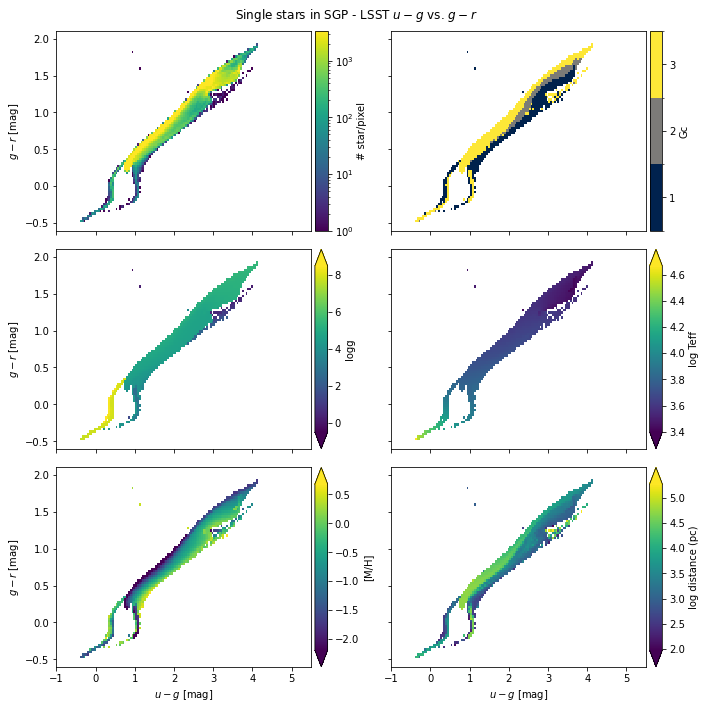

In [16]:
# 6 panel plots for stellar density, the Galactic Components, the surface gravity, and the effective temperature
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3,2, sharex = True, sharey= True, figsize = (10,10))

# 1. Stellar density
norm = colors.LogNorm(1, np.max(H))
cc = plot_2D_hess(H2, xed1, yed1, ax = ax0, norm=norm)
make_cbar(ax0, cc, "# star/pixel",  extend = None)

# 2. Galactic Components 
#    Custom normalization
ccmap = plt.get_cmap('cividis')
boundaries = np.arange(0.5, 3.6, 1)
norm_gc = colors.BoundaryNorm( boundaries, ccmap.N)
#   Plot Hess diagram
cc = plot_2D_hess(H2gc, xed1, yed1, ax = ax1, cmap = ccmap, norm = norm_gc)
#   Make colorbar with some non-default options
cb = make_cbar(ax1, cc, "Gc", boundaries = boundaries, extend = None)
cb.set_ticks(0.5*( boundaries[1:] + boundaries[:-1]) )

# 3. Surface gravity
cc = plot_2D_hess(H2logg, xed1, yed1, ax = ax2)
make_cbar(ax2, cc, "logg")

# 4. Effective Temperature
cc = plot_2D_hess(H2logte, xed1, yed1, ax = ax3)
make_cbar(ax3, cc, "log Teff")

# 5. Metallicity
cc = plot_2D_hess(H2met, xed1, yed1, ax = ax4)
make_cbar(ax4, cc, "[M/H]")

# 6. log distance(pc)
cc = plot_2D_hess(H2logdist, xed1, yed1, ax = ax5)
make_cbar(ax5, cc, "log distance (pc)")
# Set up limits for the x and y axis

ax1.set_ylim(-0.6, 2.1)
ax1.set_xlim(-1, 5.5)

# Axis labels
for ax in [ax0,ax2, ax4]:
    ax.set_ylabel("$g -r$ [mag]")
for ax in [ax4,ax5]:
    ax.set_xlabel("$u - g$ [mag]")

# Set a title for the entire figure
plt.suptitle("Single stars in SGP - LSST $u-g$ vs. $g-r$")

# Use tight_layout
plt.tight_layout()

<a class="anchor" id="resources"></a>
## Resources and references

astroML examples: https://www.astroml.org/examples/datasets/plot_SDSS_SSPP.html

LSST White paper: Dal Tio et al., 2022, "Simulating the Legacy Survey of Space and Time Stellar Content with TRILEGAL", ApJS, 262, 22. https://doi.org/10.3847/1538-4365/ac7be6